# Bayesian Filtering and Smoothing in `probnum`
## Tutorial

Provided are four examples of state-space models on which one can perform Bayesian filtering and smoothing in order to obtain
a posterior distribution over a latent state trajectory based on noisy observations.
In order to understand the theory behind these methods in detail we refer to [1].

We provide examples for four different types of state-space model:
1. [Linear, Discrete State-Space Model](#Bayesian-Inference-in-a-Linear-Discrete-State-Space-Model:-Car-Tracking): Car Tracking
2. [Linear, Continuous-Discrete State-Space Model](#Bayesian-Inference-in-a-Linear-Continuous-Discrete-State-Space-Model:-Ornstein-Uhlenbeck-Process): The Ornstein-Uhlenbeck Process
3. [Non-linear, Discrete State-Space Model](#Bayesian-Inference-in-a-Non-Linear-Discrete-State-Space-Model:-Pendulum): Pendulum
4. [Non-linear, Continuous-Discrete State-Space Model](#Bayesian-Inference-in-a-Non-Linear-Continuous-Discrete-State-Space-Model:-Benes-Daum-Filter)

In order to perform Bayesian Filtering and Smoothing on non-linear models, we show how `probnum` provides easy-to-use functionalities to
either linearise the respective model (Extended Kalman Filter, EKF) or to use an Unscented Transform (Unscented Kalman Filter, UKF).

> [1] Applied Stochastic Differential Equations, Särkkä, S. and Solin, A.. 2019.

In [1]:
import numpy as np

import probnum as pn
import probnum.filtsmooth as pnfs
import probnum.random_variables as pnrv

In [2]:
np.random.seed(12345)

In [3]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('../probnum.mplstyle')

# Bayesian Inference in a **Linear Discrete** State-Space Model: Car Tracking
---

**TODO**: Description

## Define State-Space Model

### I. Discrete, Linear Dynamics Model

In [4]:
state_dim = 4
observation_dim = 2

In [5]:
delta_t = 0.2
# Define linear transition operator
dynamics_transition_matrix = np.eye(state_dim) + delta_t * np.diag(np.ones(2), 2)
# Define process noise (covariance) matrix
process_noise_matrix = (
    np.diag(np.array([delta_t ** 3 / 3, delta_t ** 3 / 3, delta_t, delta_t]))
    + np.diag(np.array([delta_t ** 2 / 2, delta_t ** 2 / 2]), 2)
    + np.diag(np.array([delta_t ** 2 / 2, delta_t ** 2 / 2]), -2)
)

In [6]:
# Create discrete, Linear Time-Invariant Gaussian dynamics model
dynamics_model = pnfs.statespace.DiscreteLTIGaussian(
    dynamicsmat=dynamics_transition_matrix, 
    forcevec=np.zeros(state_dim),
    diffmat=process_noise_matrix,
)

### II. Discrete, Linear Measurement Model

In [7]:
measurement_marginal_variance = 0.5
# Define linear measurement matrix (often a projection to observable components of the state vector)
measurement_matrix = np.eye(observation_dim, state_dim)
# Define measurement noise (covariance) matrix
measurement_noise_matrix = measurement_marginal_variance * np.eye(observation_dim)

In [8]:
measurement_model = pnfs.statespace.DiscreteLTIGaussian(
    dynamicsmat=measurement_matrix,
    forcevec=np.zeros(observation_dim),
    diffmat=measurement_noise_matrix,
)

### III. Initial State Random Variable

In [9]:
mu_0 = np.zeros(state_dim)
sigma_0 = 0.5 * measurement_marginal_variance * np.eye(state_dim)
initial_state_rv = pnrv.Normal(mean=mu_0, cov=sigma_0)

## Generate Data for the State-Space Model

In [10]:
time_grid = np.arange(0., 20., step=delta_t)

In [11]:
latent_states, observations = pnfs.statespace.generate(
    dynmod=dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid
)

## Kalman Filtering

### I. Kalman Filter

In [12]:
kalman_filter = pnfs.Kalman(
    dynamics_model=dynamics_model,
    measurement_model=measurement_model,
    initrv=initial_state_rv
)

### II. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [13]:
state_posterior = kalman_filter.filtsmooth(
    dataset=observations,
    times=time_grid,
)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [14]:
posterior_state_rvs = state_posterior.state_rvs       # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean      # Shape: (num_time_points, state_dim)
posterior_state_covs = posterior_state_rvs.cov        # Shape: (num_time_points, state_dim, state_dim)

## Visualize Results

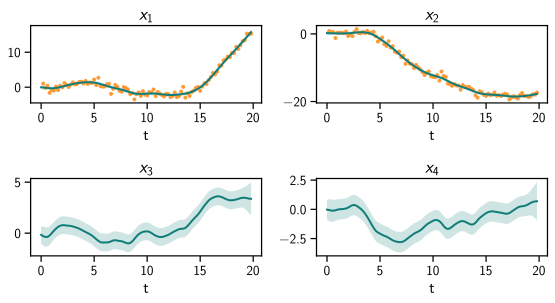

In [15]:
state_fig = plt.figure()
state_fig_gs = gridspec.GridSpec(ncols=2, nrows=2, figure=state_fig)

ax_00 = state_fig.add_subplot(state_fig_gs[0, 0])
ax_01 = state_fig.add_subplot(state_fig_gs[0, 1])
ax_10 = state_fig.add_subplot(state_fig_gs[1, 0])
ax_11 = state_fig.add_subplot(state_fig_gs[1, 1])

# Plot means
mu_x_1, mu_x_2, mu_x_3, mu_x_4 = [posterior_state_means[:, i] for i in range(state_dim)]

ax_00.plot(time_grid, mu_x_1);
ax_01.plot(time_grid, mu_x_2);
ax_10.plot(time_grid, mu_x_3);
ax_11.plot(time_grid, mu_x_4);

# Plot marginal standard deviations
std_x_1, std_x_2, std_x_3, std_x_4 = [np.sqrt(posterior_state_covs[:, i, i]) for i in range(state_dim)]

ax_00.fill_between(time_grid, mu_x_1 - 1.96 * std_x_1,  mu_x_1 + 1.96 * std_x_1, alpha=0.2);
ax_01.fill_between(time_grid, mu_x_2 - 1.96 * std_x_2,  mu_x_2 + 1.96 * std_x_2, alpha=0.2);
ax_10.fill_between(time_grid, mu_x_3 - 1.96 * std_x_3,  mu_x_3 + 1.96 * std_x_3, alpha=0.2);
ax_11.fill_between(time_grid, mu_x_4 - 1.96 * std_x_4,  mu_x_4 + 1.96 * std_x_4, alpha=0.2);

# Plot groundtruth
obs_x_1, obs_x_2 = [observations[:, i] for i in range(observation_dim)]

ax_00.scatter(time_grid[1:], obs_x_1, marker=".");
ax_01.scatter(time_grid[1:], obs_x_2, marker=".");

# Add labels etc.
ax_00.set_xlabel("t")
ax_01.set_xlabel("t")
ax_10.set_xlabel("t")
ax_11.set_xlabel("t")

ax_00.set_title(r"$x_1$")
ax_01.set_title(r"$x_2$")
ax_10.set_title(r"$x_3$")
ax_11.set_title(r"$x_4$")

state_fig.tight_layout()

# Bayesian Inference in a **Linear Continuous-Discrete** State-Space Model: Ornstein-Uhlenbeck Process
---

**TODO**: Description

## Define State-Space Model

### I. Continuous, Linear Dynamics Model

In [16]:
state_dim = 1
observation_dim = 1

In [17]:
delta_t = 0.2
# Define Linear, time-invariant Stochastic Differential Equation that models
# the (scalar) Ornstein-Uhlenbeck Process
drift_constant = 0.21
dispersion_constant = np.sqrt(0.5)
drift = -drift_constant * np.eye(state_dim)
force = np.zeros(state_dim)
dispersion = dispersion_constant * np.eye(state_dim)

In [18]:
# Create dynamics model
dynamics_model = pnfs.statespace.LTISDE(
    driftmat=drift, 
    forcevec=force,
    dispmat=dispersion,
)

### II. Discrete, Linear Measurement Model

In [19]:
measurement_marginal_variance = 0.1
# Define linear measurement matrix (often a projection to observable components of the state vector)
measurement_matrix = np.eye(observation_dim, state_dim)
# Define measurement noise (covariance) matrix
measurement_noise_matrix = measurement_marginal_variance * np.eye(observation_dim)

In [20]:
measurement_model = pnfs.statespace.DiscreteLTIGaussian(
    dynamicsmat=measurement_matrix,
    forcevec=np.zeros(observation_dim),
    diffmat=measurement_noise_matrix,
)

### III. Initial State Random Variable

In [21]:
mu_0 = 10. * np.ones(state_dim)
sigma_0 = np.eye(state_dim)
initial_state_rv = pnrv.Normal(mean=mu_0, cov=sigma_0)

## Generate Data for the State-Space Model

In [22]:
time_grid = np.arange(0., 20., step=delta_t)

In [23]:
latent_states, observations = pnfs.statespace.generate(
    dynmod=dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid
)

## Kalman Filtering

### I. Kalman Filter

In [24]:
kalman_filter = pnfs.Kalman(
    dynamics_model=dynamics_model,
    measurement_model=measurement_model,
    initrv=initial_state_rv
)

### II. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [25]:
state_posterior = kalman_filter.filtsmooth(
    dataset=observations,
    times=time_grid,
)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [26]:
posterior_state_rvs = state_posterior.state_rvs             # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean.squeeze()  # Shape: (num_time_points, )
posterior_state_covs = posterior_state_rvs.cov              # Shape: (num_time_points, )

## Visualize Results

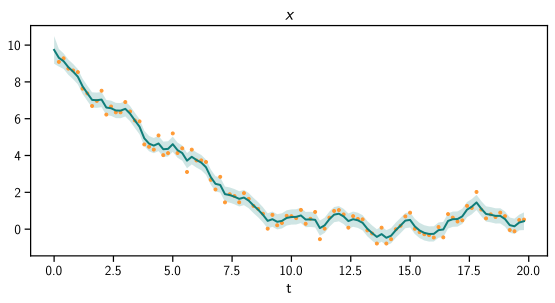

In [27]:
state_fig = plt.figure()

ax = state_fig.add_subplot()

# Plot means
ax.plot(time_grid, posterior_state_means);

# Plot marginal standard deviations
std_x = np.sqrt(posterior_state_covs).squeeze()
ax.fill_between(time_grid, posterior_state_means - 1.96 * std_x,  posterior_state_means + 1.96 * std_x, alpha=0.2);

ax.scatter(time_grid[1:], observations, marker=".");

# Add labels etc.
ax.set_xlabel("t")

ax.set_title(r"$x$")

state_fig.tight_layout()

# Bayesian Inference in a **Non-Linear Discrete** State-Space Model: Pendulum
---

**TODO**: Description

## Define State-Space Model

### I. Discrete, **Non-**Linear Dynamics Model

### **TODO:** mention that the signature for `dynamicsfun` etc is fixed, so even for time-invariant systems, `probnum` expects a `t` argument 

In [28]:
state_dim = 2
observation_dim = 1

In [29]:
# approx. gravitational constant
g = 9.81
# dt
delta_t = 0.0075

def pendulum_rhs(state):
    """Right-hand side of an ODE that defines pendulum dynamics"""
    x1, x2 = state
    y1 = x1 + x2 * delta_t
    y2 = x2 - g * np.sin(x1) * delta_t
    return np.array([y1, y2])

def pendulum_jacobian(state):
    """Jacobian of the pendulum ODE"""
    x1, x2 = state
    dy1_dx = [1.0, delta_t]
    dy2_dx = [-g * np.cos(x1) * delta_t, 1.0]
    return np.array([dy1_dx, dy2_dx])

dynamics_transition_function = lambda t, state: pendulum_rhs(state)
dynamics_transition_jacobian_function = lambda t, state: pendulum_jacobian(state)

dynamics_diffusion_matrix = 1.0 * (
    np.diag(np.array([delta_t ** 3 / 3, delta_t]))
    + np.diag(np.array([delta_t ** 2 / 2]), 1)
    + np.diag(np.array([delta_t ** 2 / 2]), -1)
)

In [30]:
# Create discrete, non-linear Gaussian dynamics model
dynamics_model = pnfs.statespace.DiscreteGaussian(
    dynamicsfun=dynamics_transition_function, 
    diffmatfun=lambda t: dynamics_diffusion_matrix,
    jacobfun=dynamics_transition_jacobian_function
)

### II. Discrete, **Non-**Linear Measurement Model

In [31]:
def pendulum_measurement(state):
    x1, x2 = state
    return np.array([np.sin(x1)])

def pendulum_measurement_jacobian(state):
    x1, x2 = state
    return np.array([[np.cos(x1), 0.0]])

measurement_function = lambda t, state: pendulum_measurement(state)
measurement_jacobian_function = lambda t, state: pendulum_measurement_jacobian(state)

measurement_variance = 0.32 ** 2
measurement_covariance = measurement_variance * np.eye(observation_dim)

In [32]:
# Create discrete, non-linear Gaussian measurement model
measurement_model = pnfs.statespace.DiscreteGaussian(
    dynamicsfun=measurement_function, 
    diffmatfun=lambda t: measurement_covariance,
    jacobfun=measurement_jacobian_function
)

### III. Initial State Random Variable

In [33]:
mu_0 = np.ones(state_dim)
sigma_0 = measurement_variance * np.eye(state_dim)
initial_state_rv = pnrv.Normal(mean=mu_0, cov=sigma_0)

## Generate Data for the State-Space Model

In [34]:
time_grid = np.arange(0., 20., step=delta_t)

In [35]:
latent_states, observations = pnfs.statespace.generate(
    dynmod=dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid
)

## Kalman Filtering

### I. Linearize model (Extended Kalman Filter)

In [36]:
linearised_dynamics_model = pnfs.DiscreteEKFComponent(dynamics_model)
linearised_measurement_model = pnfs.DiscreteEKFComponent(measurement_model)

### II. Kalman Filter

In [37]:
kalman_filter = pnfs.Kalman(
    dynamics_model=linearised_dynamics_model,
    measurement_model=linearised_measurement_model,
    initrv=initial_state_rv
)

### III. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [38]:
state_posterior = kalman_filter.filtsmooth(
    dataset=observations,
    times=time_grid,
)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [39]:
posterior_state_rvs = state_posterior.state_rvs       # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean      # Shape: (num_time_points, state_dim)
posterior_state_covs = posterior_state_rvs.cov        # Shape: (num_time_points, state_dim, state_dim)

## Visualize Results

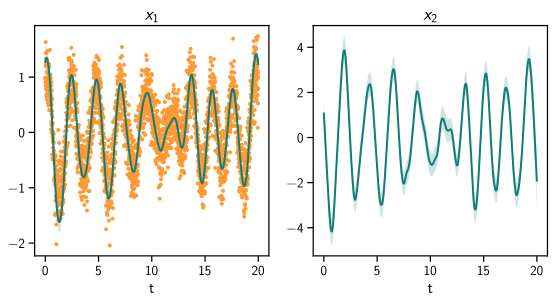

In [40]:
state_fig = plt.figure()
state_fig_gs = gridspec.GridSpec(ncols=2, nrows=1, figure=state_fig)

ax_00 = state_fig.add_subplot(state_fig_gs[0, 0])
ax_01 = state_fig.add_subplot(state_fig_gs[0, 1])

# Plot means
mu_x_1, mu_x_2 = [posterior_state_means[:, i] for i in range(state_dim)]

ax_00.plot(time_grid, mu_x_1);
ax_01.plot(time_grid, mu_x_2);

# Plot marginal standard deviations
std_x_1, std_x_2 = [np.sqrt(posterior_state_covs[:, i, i]) for i in range(state_dim)]

ax_00.fill_between(time_grid, mu_x_1 - 1.96 * std_x_1,  mu_x_1 + 1.96 * std_x_1, alpha=0.2);
ax_01.fill_between(time_grid, mu_x_2 - 1.96 * std_x_2,  mu_x_2 + 1.96 * std_x_2, alpha=0.2);

# Plot groundtruth

ax_00.scatter(time_grid[1:], observations, marker=".");

# Add labels etc.
ax_00.set_xlabel("t")
ax_01.set_xlabel("t")

ax_00.set_title(r"$x_1$")
ax_01.set_title(r"$x_2$")

state_fig.tight_layout()

# Bayesian Inference in a **Non-Linear Continuous-Discrete** State-Space Model: Benes-Daum Filter
---

**TODO**: Description

## Define State-Space Model

### I. Continuous, **Non-**Linear Dynamics Model

In [41]:
state_dim = 1
observation_dim = 1

In [42]:
drift_function = lambda t, state: np.tanh(state)
drift_function_jacobian = lambda t, state: 1.0 - np.tanh(state)**2

dispersion_matrix_function = lambda t: np.ones(state_dim)


In [43]:
# Create continuous, non-linear SDE dynamics model
dynamics_model = pnfs.statespace.SDE(
    driftfun=drift_function, 
    dispmatfun=dispersion_matrix_function,
    jacobfun=drift_function_jacobian
)

### II. Discrete, Linear Measurement Model

In [44]:
measurement_marginal_variance = 1.0
# Define linear measurement matrix (often a projection to observable components of the state vector)
measurement_matrix = np.eye(observation_dim, state_dim)
# Define measurement noise (covariance) matrix
measurement_noise_matrix = measurement_marginal_variance * np.eye(observation_dim)

In [45]:
measurement_model = pnfs.statespace.DiscreteLTIGaussian(
    dynamicsmat=measurement_matrix,
    forcevec=np.zeros(observation_dim),
    diffmat=measurement_noise_matrix,
)

### III. Initial State Random Variable

In [46]:
mu_0 = np.zeros(state_dim)
sigma_0 = 3.0 * np.eye(state_dim)
initial_state_rv = pnrv.Normal(mean=mu_0, cov=sigma_0)

## Generate Data for the State-Space Model

In [47]:
time_grid = np.arange(0., 20., step=delta_t)

In [48]:
linearised_dynamics_model = pnfs.ContinuousEKFComponent(dynamics_model, num_steps=10)

In [49]:
latent_states, observations = pnfs.statespace.generate(
    dynmod=linearised_dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid
)

## Kalman Filtering

### I. Linearize model (Extended Kalman Filter)

### II. Kalman Filter

In [50]:
kalman_filter = pnfs.Kalman(
    dynamics_model=linearised_dynamics_model,
    measurement_model=measurement_model,
    initrv=initial_state_rv
)

### III. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

# TODO: How do we get the `crosscov` for smoothing?

In [52]:
state_posterior = kalman_filter.filter(
    dataset=observations,
    times=time_grid,
)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [53]:
posterior_state_rvs = state_posterior.state_rvs                 # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean.squeeze()      # Shape: (num_time_points, state_dim)
posterior_state_covs = posterior_state_rvs.cov                  # Shape: (num_time_points, state_dim, state_dim)

## Visualize Results

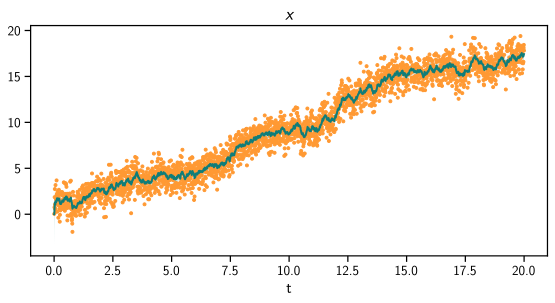

In [54]:
state_fig = plt.figure()

ax = state_fig.add_subplot()

# Plot means
ax.plot(time_grid, posterior_state_means);

# Plot marginal standard deviations
std_x = np.sqrt(posterior_state_covs).squeeze()
ax.fill_between(time_grid, posterior_state_means - 1.96 * std_x,  posterior_state_means + 1.96 * std_x, alpha=0.2);

ax.scatter(time_grid[1:], observations, marker=".");

# Add labels etc.
ax.set_xlabel("t")

ax.set_title(r"$x$")

state_fig.tight_layout()